## Importation packages

In [1]:
# File system management
import os
import pickle
import dill
import matplotlib.pyplot as plt
from matplotlib.cm import Spectral
import seaborn as sns
from collections import Counter
import numpy as np
import pandas as pd
import time

import lime
import lime.lime_tabular

import joblib

# Scikit-learn
from sklearn import datasets, preprocessing, model_selection, ensemble, pipeline
from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance

# Hyperparameters optimisation
from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials 
from hyperopt.pyll.base import scope

# CatBoost Classifier
from catboost import CatBoostClassifier

# XGBoost
import xgboost as xgb

# LightGBM
import lightgbm as ltb
from lightgbm import plot_importance

# Balancing data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Interpratability
import shap
import eli5

# Data drift
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# MLFlow
import mlflow
import mlflow.sklearn
from mlflow import log_metric, log_param, log_artifacts
from mlflow.models.signature import infer_signature

%matplotlib inline
sns.set_theme(palette="Set1")

C:\Users\JayCo\anaconda3\envs\EnvP6\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fonctions

In [2]:
# Fonction : MAtrice de confusion
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [3]:
# Fonction : courbe ROC AUC
def compute_roc_curve(y_test, y_pred_proba, 
                      model_name="Model", 
                      disp_best_th=False):
    # Compute metrics
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Create fig
    plt.figure()
    plt.title(model_name + ": ROC curve")

    # Display x=y
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')

    # Display ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', 
                 label="AUC = {:.3f}".format((auc)))

    if disp_best_th is True:
        # Compute best threshold
        o_tpr = tpr[np.argmin(np.abs(fpr+tpr-1))]
        o_fpr = fpr[np.argmin(np.abs(fpr+tpr-1))]
        o_threshold = thresholds[np.argmin(np.abs(fpr+tpr-1))]

        # Display best threshold
        sns.scatterplot(x=[o_fpr], 
                        y=[o_tpr], 
                        legend='brief', 
                        label="Best threshold = {:.3f}".format(o_threshold))

    plt.ylabel('Taux vrais positifs')
    plt.xlabel('Taux faux positifs')
    plt.legend(loc=4)
    plt.show()

    # Return AUC score
    return auc

In [4]:
# Fonction : MLFlow génération métriques
def log_mlflow(model, name, custom_score, n_estimator=None, 
               max_depth=None, auc_score=None, f1_score=None, 
               acc_score=None, train_class_0=None, train_class_1=None):

    # Track params and metrics 
    with mlflow.start_run():
        # Set run name
        mlflow.set_tag("mlflow.runName", name)

        # Set parameters
        mlflow.log_param("n_estimators", n_estimator)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("train_class_0", train_class_0)
        mlflow.log_param("train_class_1", train_class_1)

        # Set metrics
        mlflow.log_metric("Custom score", custom_score)
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("F1", f1_score)
        mlflow.log_metric("Accuracy", acc_score)

        # Save model to artifacts
        mlflow.sklearn.log_model(model, name)

    mlflow.end_run()

In [5]:
# Fonction : business score
def business_loss_func(y_true, y_pred):
    tp, fp, fn, tn = confusion_matrix(y_true, y_pred).ravel()
    cost = (fp + (10 * fn)) / len(y_true)
    return float(cost)

In [6]:
# Fonction prédiction et matrice de confusion
def compute_classification_results(model, model_name, x_test, y_test):

    # Prédiction target == 1 (incident de paiement)
    y_pred_proba = model.predict_proba(x_test)[:,1]
    y_pred = model.predict(x_test)

    # Matrice de confusion
    display_confusion_matrix(y_test, y_pred, model_name=model_name)

    # Courbe ROC
    auc_score = compute_roc_curve(y_test, y_pred_proba, model_name=model_name)

    # Calcul des scores
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    display(clf_report)

    # Business Loss Function
    business_score = business_loss_func(y_test, y_pred)
    print("Business score =", business_score)

    return business_score, auc_score, clf_report

In [7]:
# Fonction : features importance
def display_importances(feature_importance_df_):
    
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

## Datasets

#### Choix des paramètres

In [8]:
# Paramètres généraux modélisation (split rate + random_state)
split_rate = 0.8
rs = 42

# Imputation valeurs nulles
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')

# Encodage
scaler = preprocessing.MinMaxScaler()

#### Ouverture du Dataset

In [9]:
# Chemin des Dataset après feature engineering
path = './preprocessed_data/'

# Ouverture des Dataset 
data_train = pd.read_csv(path+'df_train.csv', index_col=[0])
data_train.set_index('SK_ID_CURR', inplace = True)
data_test = pd.read_csv(path+'df_test_compressed.gzip', index_col=[0], compression='gzip')

# Définition de la target (Y)
Y = data_train['TARGET'].to_numpy()
data_train.drop(columns='TARGET', inplace=True)

# Définition de la liste des features de X
features_names = data_train.columns.to_list()

# Imputation des valeurs nulles de X
X = imputer.fit_transform(data_train)

# Formats des Dataset
display(f'Format de X (features) : {X.shape}')
display(f'Format de Y (target) : {Y.shape}')

'Format de X (features) : (307507, 604)'

'Format de Y (target) : (307507,)'

#### Data split

In [10]:
# Split du fichier train pour entraînement des modèles
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y, 
                                                    train_size = split_rate,
                                                    shuffle = True,
                                                    stratify = Y,
                                                    random_state = rs)

# Affichage des formats post splits
display(f'Format de X_train : {X_train.shape}')
display(f'Format de X_test : {X_test.shape}')
display(f'Format de y_train : {y_train.shape}')
display(f'Format de y_test : {y_test.shape}')

'Format de X_train : (246005, 604)'

'Format de X_test : (61502, 604)'

'Format de y_train : (246005,)'

'Format de y_test : (61502,)'

#### Standardisation

In [11]:
# Standardisation
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Data balance (SMOTE)

#### Rappel :  
  
"Le déséquilibre entre le nombre de bons et de moins bons clients doit être pris en compte pour élaborer un modèle pertinent, à l’aide d’au moins une méthode au choix"

In [12]:
# Répartition initiale des classes
initial_counter = Counter(y_train)
print(f'Répartition initiale de la target Y : {initial_counter}')

# Définition du pipeline SMOTE
seed=21
over = SMOTE(sampling_strategy=0.1, random_state=seed)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=seed)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Application aux Datasets
X_train_scaled_smote, y_train_smote = \
    pipeline.fit_resample(X_train_scaled, y_train)
X_test_scaled_smote, y_test_smote = \
    pipeline.fit_resample(X_test_scaled, y_test)

# Répartition après oversampling SMOTE paramètres par défaut
smote_counter = Counter(y_train_smote)
print(f'Répartition finale de la target Y (avec SMOTE) : {smote_counter}')

Répartition initiale de la target Y : Counter({0.0: 226145, 1.0: 19860})
Répartition finale de la target Y (avec SMOTE) : Counter({0.0: 45228, 1.0: 22614})


## Custome loss function

#### Rappel :  
  
"Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge).
Vous pourrez supposer, par exemple, que le coût d’un FN est dix fois supérieur au coût d’un FP."

In [13]:
business_score = make_scorer(business_loss_func, greater_is_better = False)

## Classification (unbalanced)

#### RandomForest Classifier

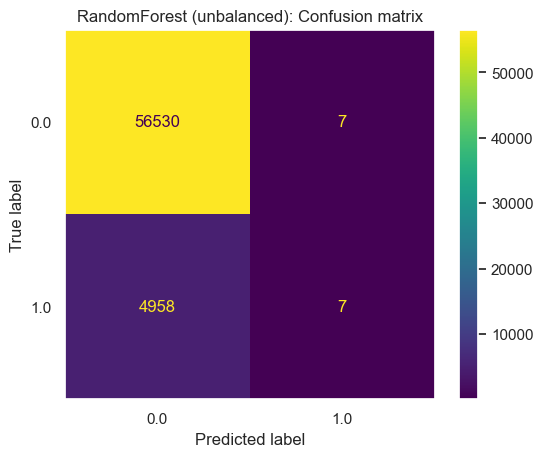

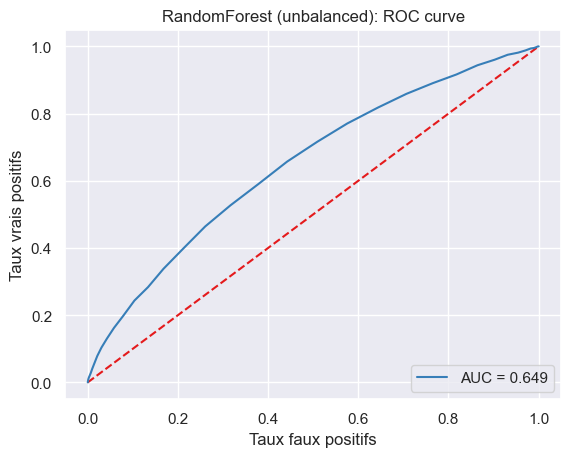

,precision,recall,f1-score,support
0.0,0.919366,0.999876,0.957933,56537.000000
1.0,0.500000,0.001410,0.002812,4965.000000
accuracy,0.919271,0.919271,0.919271,0.919271
macro avg,0.709683,0.500643,0.480372,61502.000000
weighted avg,0.885511,0.919271,0.880827,61502.000000


Business score = 0.806266462879256


Setuptools is replacing distutils.


CPU times: total: 4min 5s
Wall time: 4min 8s


In [14]:
%%time

rf = RandomForestClassifier(random_state = rs)
rf_name = 'RandomForest (unbalanced)'

# Train model
start_rf = time.time()
rf.fit(X_train_scaled, y_train)
end_rf = time.time()
time_rf = round(end_rf - start_rf, 2)

# Compute results
rf_business_score, rf_auc, rf_report = \
                        compute_classification_results(rf, 
                                                       rf_name, 
                                                       X_test_scaled, 
                                                       y_test)

# Save logs
rf_params = rf.get_params()
log_mlflow(rf, rf_name,
           custom_score=rf_business_score,
           auc_score=rf_auc,
           f1_score=rf_report.loc['weighted avg', 'f1-score'], 
           acc_score=rf_report.loc['accuracy', 'precision'],
           n_estimator=rf_params['n_estimators'],
           max_depth=rf_params['max_depth'], 
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

#### XGBoost

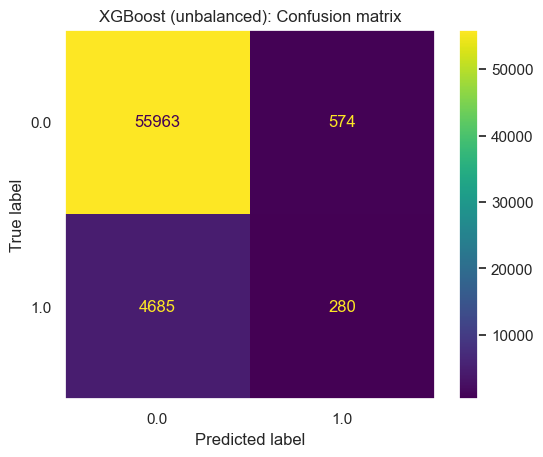

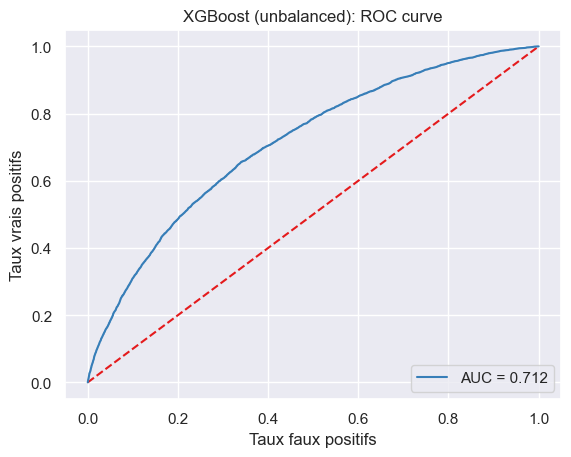

,precision,recall,f1-score,support
0.0,0.922751,0.989847,0.955122,56537.000000
1.0,0.327869,0.056395,0.096236,4965.000000
accuracy,0.914491,0.914491,0.914491,0.914491
macro avg,0.625310,0.523121,0.525679,61502.000000
weighted avg,0.874727,0.914491,0.885785,61502.000000


Business score = 0.7710968748983773
CPU times: total: 12min 50s
Wall time: 1min 58s


In [15]:
%%time

# Create XGBoost classifier
xgbc = xgb.XGBClassifier(random_state = rs)
xgbc_name = 'XGBoost (unbalanced)'

# Train model
start_xg = time.time()
xgbc.fit(X_train_scaled, y_train)
end_xg = time.time()
time_xg = round(end_xg - start_xg, 2)

# Compute results
xgbc_business_score, xgbc_auc, xgbc_report = \
                        compute_classification_results(xgbc, 
                                                       xgbc_name, 
                                                       X_test_scaled, 
                                                       y_test)

# Save logs
xgbc_params = xgbc.get_params()
log_mlflow(xgbc, xgbc_name,
           custom_score=xgbc_business_score,
           auc_score=xgbc_auc,
           f1_score=xgbc_report.loc['weighted avg', 'f1-score'], 
           acc_score=xgbc_report.loc['accuracy', 'precision'],
           n_estimator=xgbc_params['n_estimators'],
           max_depth=xgbc_params['max_depth'], 
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

#### LightGBM

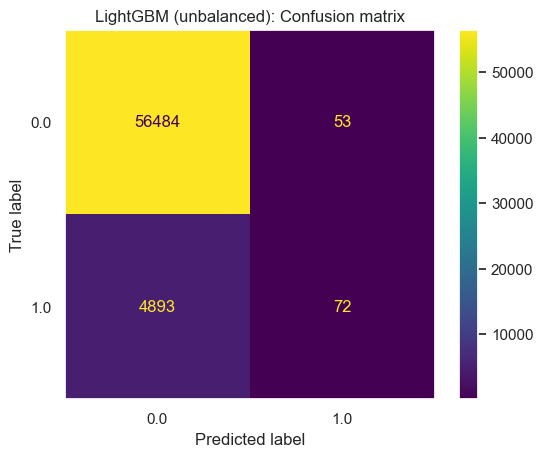

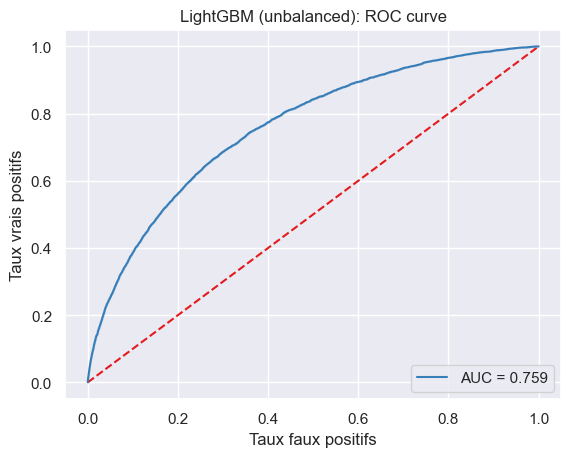

,precision,recall,f1-score,support
0.0,0.920280,0.999063,0.958054,56537.00000
1.0,0.576000,0.014502,0.028291,4965.00000
accuracy,0.919580,0.919580,0.919580,0.91958
macro avg,0.748140,0.506782,0.493172,61502.00000
weighted avg,0.892486,0.919580,0.882995,61502.00000


Business score = 0.7964456440440961
CPU times: total: 1min 59s
Wall time: 57.6 s


In [16]:
%%time

# Create LightGBM classifier
lgbm = ltb.LGBMClassifier(random_state = rs)
lgbm_name = 'LightGBM (unbalanced)'

# Train model
start_lgbm = time.time()
lgbm.fit(X_train_scaled, y_train)
end_lgbm = time.time()
time_lgbm = round(end_lgbm - start_lgbm, 2)

# Compute results
lgbm_business_score, lgbm_auc, lgbm_report = \
                        compute_classification_results(lgbm, 
                                                       lgbm_name, 
                                                       X_test_scaled, 
                                                       y_test)

# Save logs
lgbm_params = lgbm.get_params()
log_mlflow(lgbm, lgbm_name,
           custom_score=lgbm_business_score,
           auc_score=lgbm_auc,
           f1_score=lgbm_report.loc['weighted avg', 'f1-score'], 
           acc_score=lgbm_report.loc['accuracy', 'precision'],
           n_estimator=lgbm_params['n_estimators'],
           max_depth=lgbm_params['max_depth'], 
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

#### CatBoost Classifier

Learning rate set to 0.10811
0:	learn: 0.5859160	total: 242ms	remaining: 4m 1s
1:	learn: 0.5037019	total: 326ms	remaining: 2m 42s
2:	learn: 0.4468855	total: 406ms	remaining: 2m 14s
3:	learn: 0.4053434	total: 479ms	remaining: 1m 59s
4:	learn: 0.3692949	total: 559ms	remaining: 1m 51s
5:	learn: 0.3444274	total: 632ms	remaining: 1m 44s
6:	learn: 0.3253172	total: 704ms	remaining: 1m 39s
7:	learn: 0.3090488	total: 780ms	remaining: 1m 36s
8:	learn: 0.2979006	total: 853ms	remaining: 1m 33s
9:	learn: 0.2888024	total: 940ms	remaining: 1m 33s
10:	learn: 0.2812161	total: 1.02s	remaining: 1m 31s
11:	learn: 0.2754483	total: 1.1s	remaining: 1m 30s
12:	learn: 0.2712189	total: 1.18s	remaining: 1m 29s
13:	learn: 0.2674265	total: 1.26s	remaining: 1m 28s
14:	learn: 0.2644431	total: 1.34s	remaining: 1m 28s
15:	learn: 0.2620542	total: 1.43s	remaining: 1m 28s
16:	learn: 0.2601625	total: 1.5s	remaining: 1m 26s
17:	learn: 0.2584301	total: 1.57s	remaining: 1m 25s
18:	learn: 0.2568909	total: 1.66s	remaining: 1m 

159:	learn: 0.2343418	total: 13.4s	remaining: 1m 10s
160:	learn: 0.2342964	total: 13.5s	remaining: 1m 10s
161:	learn: 0.2342065	total: 13.6s	remaining: 1m 10s
162:	learn: 0.2341177	total: 13.7s	remaining: 1m 10s
163:	learn: 0.2340732	total: 13.7s	remaining: 1m 10s
164:	learn: 0.2339838	total: 13.8s	remaining: 1m 10s
165:	learn: 0.2339260	total: 13.9s	remaining: 1m 9s
166:	learn: 0.2338545	total: 14s	remaining: 1m 9s
167:	learn: 0.2338107	total: 14.1s	remaining: 1m 9s
168:	learn: 0.2338030	total: 14.2s	remaining: 1m 9s
169:	learn: 0.2337191	total: 14.2s	remaining: 1m 9s
170:	learn: 0.2336406	total: 14.3s	remaining: 1m 9s
171:	learn: 0.2335738	total: 14.4s	remaining: 1m 9s
172:	learn: 0.2335224	total: 14.5s	remaining: 1m 9s
173:	learn: 0.2334404	total: 14.6s	remaining: 1m 9s
174:	learn: 0.2333548	total: 14.7s	remaining: 1m 9s
175:	learn: 0.2332864	total: 14.7s	remaining: 1m 9s
176:	learn: 0.2332030	total: 14.8s	remaining: 1m 8s
177:	learn: 0.2331608	total: 14.9s	remaining: 1m 8s
178:	lea

320:	learn: 0.2260610	total: 25.7s	remaining: 54.3s
321:	learn: 0.2260186	total: 25.8s	remaining: 54.2s
322:	learn: 0.2259636	total: 25.8s	remaining: 54.2s
323:	learn: 0.2259137	total: 25.9s	remaining: 54.1s
324:	learn: 0.2258678	total: 26s	remaining: 54s
325:	learn: 0.2258192	total: 26.1s	remaining: 53.9s
326:	learn: 0.2257908	total: 26.2s	remaining: 53.8s
327:	learn: 0.2257626	total: 26.2s	remaining: 53.7s
328:	learn: 0.2257158	total: 26.3s	remaining: 53.6s
329:	learn: 0.2256605	total: 26.4s	remaining: 53.5s
330:	learn: 0.2256224	total: 26.5s	remaining: 53.5s
331:	learn: 0.2255839	total: 26.5s	remaining: 53.4s
332:	learn: 0.2255254	total: 26.6s	remaining: 53.3s
333:	learn: 0.2254495	total: 26.7s	remaining: 53.2s
334:	learn: 0.2254099	total: 26.8s	remaining: 53.1s
335:	learn: 0.2253732	total: 26.8s	remaining: 53.1s
336:	learn: 0.2253365	total: 26.9s	remaining: 53s
337:	learn: 0.2252750	total: 27s	remaining: 52.9s
338:	learn: 0.2252150	total: 27.1s	remaining: 52.8s
339:	learn: 0.225172

480:	learn: 0.2195194	total: 37.7s	remaining: 40.7s
481:	learn: 0.2194903	total: 37.8s	remaining: 40.6s
482:	learn: 0.2194301	total: 37.9s	remaining: 40.5s
483:	learn: 0.2193981	total: 38s	remaining: 40.5s
484:	learn: 0.2193686	total: 38s	remaining: 40.4s
485:	learn: 0.2193116	total: 38.1s	remaining: 40.3s
486:	learn: 0.2192658	total: 38.2s	remaining: 40.2s
487:	learn: 0.2192168	total: 38.2s	remaining: 40.1s
488:	learn: 0.2191804	total: 38.3s	remaining: 40.1s
489:	learn: 0.2191550	total: 38.4s	remaining: 40s
490:	learn: 0.2191283	total: 38.5s	remaining: 39.9s
491:	learn: 0.2190841	total: 38.5s	remaining: 39.8s
492:	learn: 0.2190431	total: 38.6s	remaining: 39.7s
493:	learn: 0.2190265	total: 38.7s	remaining: 39.6s
494:	learn: 0.2189907	total: 38.8s	remaining: 39.5s
495:	learn: 0.2189361	total: 38.8s	remaining: 39.5s
496:	learn: 0.2188847	total: 38.9s	remaining: 39.4s
497:	learn: 0.2188539	total: 39s	remaining: 39.3s
498:	learn: 0.2188085	total: 39.1s	remaining: 39.2s
499:	learn: 0.218773

640:	learn: 0.2135776	total: 50.2s	remaining: 28.1s
641:	learn: 0.2135344	total: 50.3s	remaining: 28s
642:	learn: 0.2134909	total: 50.4s	remaining: 28s
643:	learn: 0.2134489	total: 50.4s	remaining: 27.9s
644:	learn: 0.2133987	total: 50.5s	remaining: 27.8s
645:	learn: 0.2133724	total: 50.6s	remaining: 27.7s
646:	learn: 0.2133349	total: 50.7s	remaining: 27.6s
647:	learn: 0.2132838	total: 50.7s	remaining: 27.6s
648:	learn: 0.2132496	total: 50.8s	remaining: 27.5s
649:	learn: 0.2132243	total: 50.9s	remaining: 27.4s
650:	learn: 0.2132045	total: 50.9s	remaining: 27.3s
651:	learn: 0.2131621	total: 51s	remaining: 27.2s
652:	learn: 0.2131346	total: 51.1s	remaining: 27.2s
653:	learn: 0.2131007	total: 51.2s	remaining: 27.1s
654:	learn: 0.2130592	total: 51.2s	remaining: 27s
655:	learn: 0.2130182	total: 51.3s	remaining: 26.9s
656:	learn: 0.2129819	total: 51.4s	remaining: 26.8s
657:	learn: 0.2129553	total: 51.5s	remaining: 26.8s
658:	learn: 0.2129236	total: 51.5s	remaining: 26.7s
659:	learn: 0.212900

802:	learn: 0.2082462	total: 1m 2s	remaining: 15.3s
803:	learn: 0.2081954	total: 1m 2s	remaining: 15.2s
804:	learn: 0.2081395	total: 1m 2s	remaining: 15.1s
805:	learn: 0.2081077	total: 1m 2s	remaining: 15s
806:	learn: 0.2080912	total: 1m 2s	remaining: 15s
807:	learn: 0.2080638	total: 1m 2s	remaining: 14.9s
808:	learn: 0.2080151	total: 1m 2s	remaining: 14.8s
809:	learn: 0.2079687	total: 1m 2s	remaining: 14.7s
810:	learn: 0.2079406	total: 1m 2s	remaining: 14.6s
811:	learn: 0.2079117	total: 1m 2s	remaining: 14.6s
812:	learn: 0.2078843	total: 1m 2s	remaining: 14.5s
813:	learn: 0.2078644	total: 1m 3s	remaining: 14.4s
814:	learn: 0.2078342	total: 1m 3s	remaining: 14.3s
815:	learn: 0.2078013	total: 1m 3s	remaining: 14.3s
816:	learn: 0.2077600	total: 1m 3s	remaining: 14.2s
817:	learn: 0.2077150	total: 1m 3s	remaining: 14.1s
818:	learn: 0.2076543	total: 1m 3s	remaining: 14s
819:	learn: 0.2076340	total: 1m 3s	remaining: 13.9s
820:	learn: 0.2075903	total: 1m 3s	remaining: 13.9s
821:	learn: 0.2075

961:	learn: 0.2032552	total: 1m 14s	remaining: 2.93s
962:	learn: 0.2032375	total: 1m 14s	remaining: 2.86s
963:	learn: 0.2032248	total: 1m 14s	remaining: 2.78s
964:	learn: 0.2031927	total: 1m 14s	remaining: 2.7s
965:	learn: 0.2031624	total: 1m 14s	remaining: 2.62s
966:	learn: 0.2031248	total: 1m 14s	remaining: 2.55s
967:	learn: 0.2031033	total: 1m 14s	remaining: 2.47s
968:	learn: 0.2030685	total: 1m 14s	remaining: 2.39s
969:	learn: 0.2030483	total: 1m 14s	remaining: 2.31s
970:	learn: 0.2030111	total: 1m 14s	remaining: 2.24s
971:	learn: 0.2029703	total: 1m 15s	remaining: 2.16s
972:	learn: 0.2029469	total: 1m 15s	remaining: 2.08s
973:	learn: 0.2028989	total: 1m 15s	remaining: 2.01s
974:	learn: 0.2028534	total: 1m 15s	remaining: 1.93s
975:	learn: 0.2028405	total: 1m 15s	remaining: 1.85s
976:	learn: 0.2028054	total: 1m 15s	remaining: 1.77s
977:	learn: 0.2027735	total: 1m 15s	remaining: 1.7s
978:	learn: 0.2027367	total: 1m 15s	remaining: 1.62s
979:	learn: 0.2027085	total: 1m 15s	remaining: 1

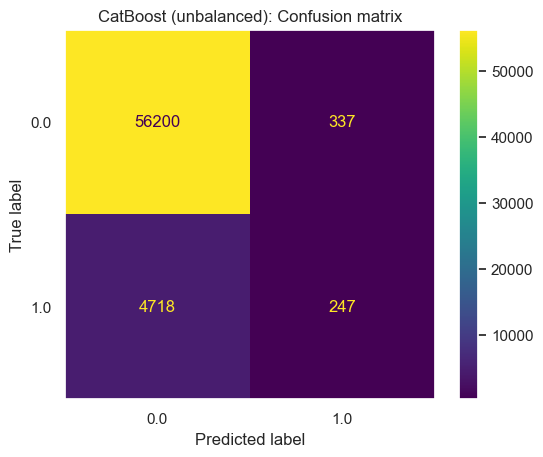

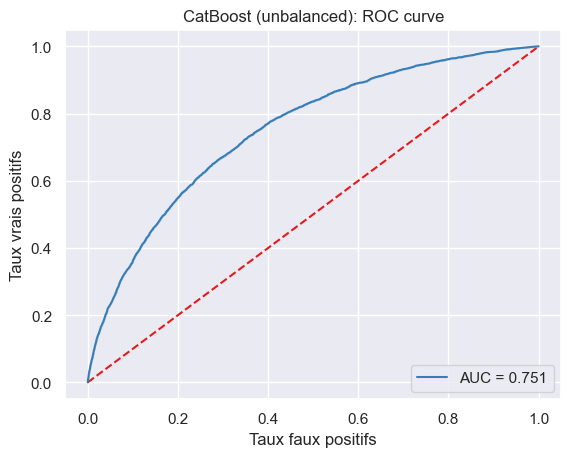

,precision,recall,f1-score,support
0.0,0.922552,0.994039,0.956962,56537.000000
1.0,0.422945,0.049748,0.089025,4965.000000
accuracy,0.917808,0.917808,0.917808,0.917808
macro avg,0.672748,0.521894,0.522994,61502.000000
weighted avg,0.882219,0.917808,0.886894,61502.000000


Business score = 0.7726090208448506


KeyError: 'n_estimators'

In [17]:
%%time

# Create CatBoost classifier
cbcm = CatBoostClassifier(random_state = rs)
cbcm_name = 'CatBoost (unbalanced)'

# Train model
start_cb = time.time()
cbcm.fit(X_train_scaled, y_train)
end_cb = time.time()
time_cb = round(end_cb - start_cb, 2)

# Compute results
cbcm_business_score, cbcm_auc, cbcm_report = \
                        compute_classification_results(cbcm, 
                                                       cbcm_name, 
                                                       X_test_scaled, 
                                                       y_test)

# Save logs
cbcm_params = cbcm.get_params()
log_mlflow(cbcm, cbcm_name,
           custom_score=cbcm_business_score,
           auc_score=cbcm_auc,
           f1_score=cbcm_report.loc['weighted avg', 'f1-score'], 
           acc_score=cbcm_report.loc['accuracy', 'precision'],
           n_estimator=cbcm_params['n_estimators'],
           max_depth=cbcm_params['max_depth'], 
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

## Classification (balanced with SMOTE)

#### RandomForest (balanced with SMOTE)

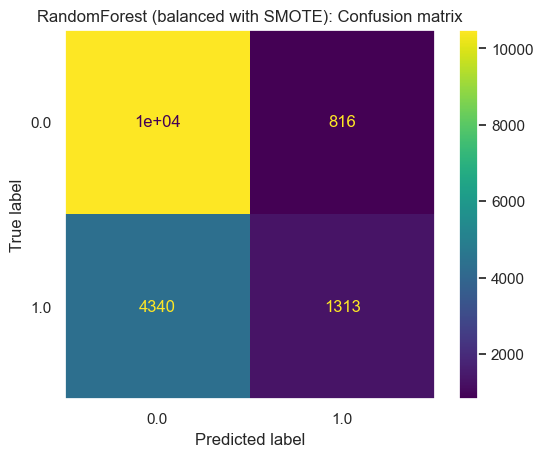

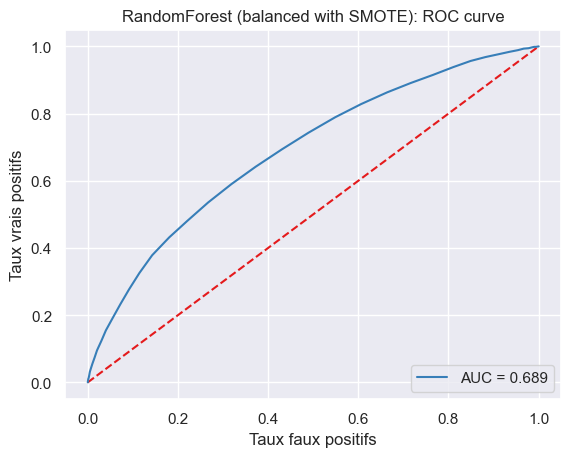

,precision,recall,f1-score,support
0.0,0.707350,0.927826,0.802724,11306.000000
1.0,0.616721,0.232266,0.337445,5653.000000
accuracy,0.695973,0.695973,0.695973,0.695973
macro avg,0.662036,0.580046,0.570085,16959.000000
weighted avg,0.677140,0.695973,0.647631,16959.000000


Business score = 2.607229199834896
CPU times: total: 46 s
Wall time: 48.5 s


In [18]:
%%time

rfb = RandomForestClassifier(random_state = rs)
rfb_name = 'RandomForest (balanced with SMOTE)'

# Train model
start_rfb = time.time()
rfb.fit(X_train_scaled_smote, y_train_smote)
end_rfb = time.time()
time_rfb = round(end_rfb - start_rfb, 2)

# Compute results
rfb_business_score, rfb_auc, rfb_report = \
                        compute_classification_results(rfb, 
                                                       rfb_name, 
                                                       X_test_scaled_smote, 
                                                       y_test_smote)

# Save logs
rfb_params = rfb.get_params()
log_mlflow(rfb, rfb_name,
           custom_score=rfb_business_score,
           auc_score=rfb_auc,
           f1_score=rfb_report.loc['weighted avg', 'f1-score'], 
           acc_score=rfb_report.loc['accuracy', 'precision'],
           n_estimator=rfb_params['n_estimators'],
           max_depth=rfb_params['max_depth'], 
           train_class_0=Counter(y_train_smote)[0],
           train_class_1=Counter(y_train_smote)[1])

#### XGBoost (balanced with SMOTE)

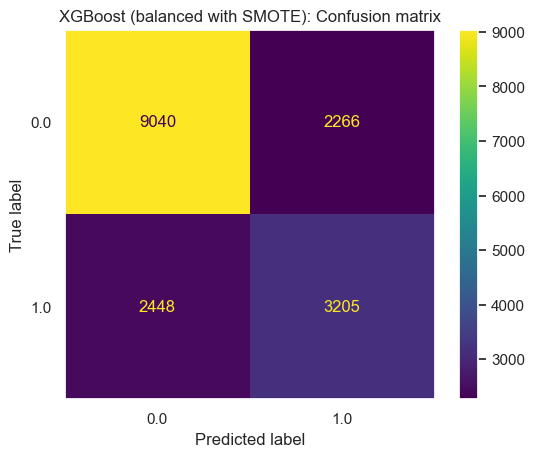

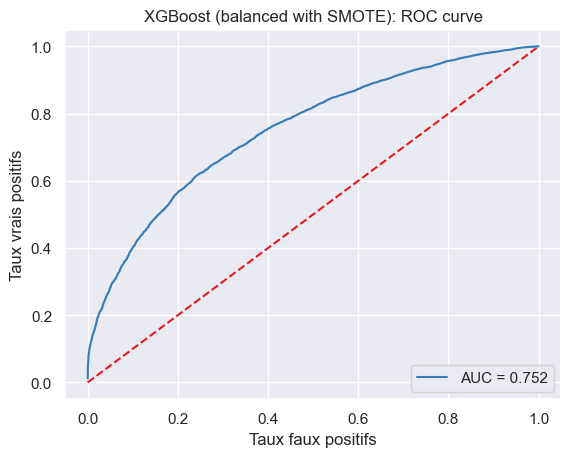

,precision,recall,f1-score,support
0.0,0.786908,0.799575,0.793191,11306.000000
1.0,0.585816,0.566956,0.576232,5653.000000
accuracy,0.722035,0.722035,0.722035,0.722035
macro avg,0.686362,0.683266,0.684711,16959.000000
weighted avg,0.719877,0.722035,0.720871,16959.000000


Business score = 1.5770977062326788
CPU times: total: 4min 15s
Wall time: 57.7 s


In [19]:
%%time

# Create XGBoost classifier
xgbcb = xgb.XGBClassifier(random_state = rs)
xgbcb_name = 'XGBoost (balanced with SMOTE)'

# Train model
start_xgb = time.time()
xgbcb.fit(X_train_scaled_smote, y_train_smote)
end_xgb = time.time()
time_xgb = round(end_xgb - start_xgb, 2)

# Compute results
xgbcb_business_score, xgbcb_auc, xgbcb_report = \
                        compute_classification_results(xgbcb, 
                                                       xgbcb_name, 
                                                       X_test_scaled_smote, 
                                                       y_test_smote)

# Save logs
xgbcb_params = xgbcb.get_params()
log_mlflow(xgbcb, xgbcb_name,
           custom_score=xgbcb_business_score,
           auc_score=xgbcb_auc,
           f1_score=xgbcb_report.loc['weighted avg', 'f1-score'], 
           acc_score=xgbcb_report.loc['accuracy', 'precision'],
           n_estimator=xgbcb_params['n_estimators'],
           max_depth=xgbcb_params['max_depth'], 
           train_class_0=Counter(y_train_smote)[0],
           train_class_1=Counter(y_train_smote)[1])

#### LightGBM (balanced with SMOTE)

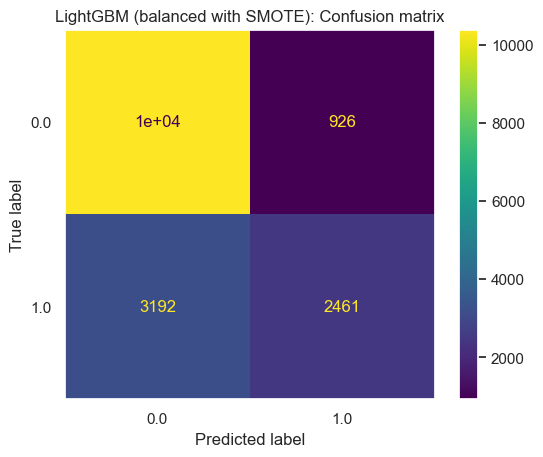

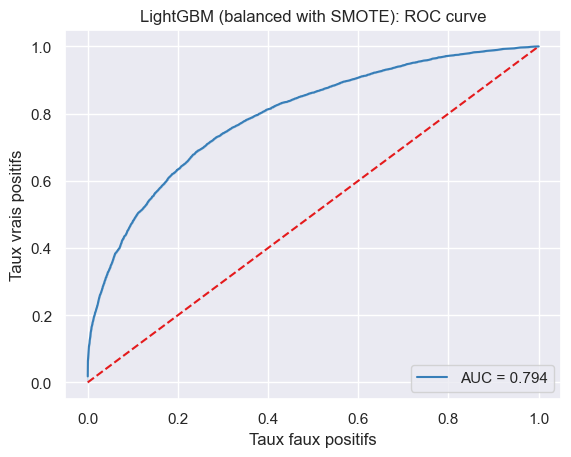

,precision,recall,f1-score,support
0.0,0.764810,0.918097,0.834472,11306.000000
1.0,0.726602,0.435344,0.544469,5653.000000
accuracy,0.757179,0.757179,0.757179,0.757179
macro avg,0.745706,0.676720,0.689471,16959.000000
weighted avg,0.752074,0.757179,0.737804,16959.000000


Business score = 1.9367887257503391
CPU times: total: 1min 1s
Wall time: 38.3 s


In [20]:
%%time

# Create LightGBM classifier
lgbmb = ltb.LGBMClassifier(random_state = rs)
lgbmb_name = 'LightGBM (balanced with SMOTE)'

# Train model
start_lgbmb = time.time()
lgbmb.fit(X_train_scaled_smote, y_train_smote)
end_lgbmb = time.time()
time_lgbmb = round(end_lgbmb - start_lgbmb, 2)

# Compute results
lgbmb_business_score, lgbmb_auc, lgbmb_report = \
                        compute_classification_results(lgbmb, 
                                                       lgbmb_name, 
                                                       X_test_scaled_smote, 
                                                       y_test_smote)

# Save logs
lgbmb_params = lgbmb.get_params()
log_mlflow(lgbmb, lgbmb_name,
           custom_score=lgbmb_business_score,
           auc_score=lgbmb_auc,
           f1_score=lgbmb_report.loc['weighted avg', 'f1-score'], 
           acc_score=lgbmb_report.loc['accuracy', 'precision'],
           n_estimator=lgbmb_params['n_estimators'],
           max_depth=lgbmb_params['max_depth'], 
           train_class_0=Counter(y_train_smote)[0],
           train_class_1=Counter(y_train_smote)[1])

#### CatBoostClassifier (balanced with SMOTE)

Learning rate set to 0.062371
0:	learn: 0.6775431	total: 45.2ms	remaining: 45.2s
1:	learn: 0.6645148	total: 91.1ms	remaining: 45.5s
2:	learn: 0.6524944	total: 138ms	remaining: 45.8s
3:	learn: 0.6416494	total: 183ms	remaining: 45.5s
4:	learn: 0.6327278	total: 230ms	remaining: 45.7s
5:	learn: 0.6244795	total: 274ms	remaining: 45.5s
6:	learn: 0.6171966	total: 317ms	remaining: 45s
7:	learn: 0.6108050	total: 362ms	remaining: 44.9s
8:	learn: 0.6048215	total: 407ms	remaining: 44.8s
9:	learn: 0.5997249	total: 450ms	remaining: 44.5s
10:	learn: 0.5945189	total: 496ms	remaining: 44.6s
11:	learn: 0.5904793	total: 541ms	remaining: 44.5s
12:	learn: 0.5868065	total: 584ms	remaining: 44.3s
13:	learn: 0.5829867	total: 629ms	remaining: 44.3s
14:	learn: 0.5798892	total: 675ms	remaining: 44.3s
15:	learn: 0.5770534	total: 718ms	remaining: 44.2s
16:	learn: 0.5737002	total: 767ms	remaining: 44.3s
17:	learn: 0.5712385	total: 812ms	remaining: 44.3s
18:	learn: 0.5690571	total: 855ms	remaining: 44.1s
19:	learn: 

161:	learn: 0.4938618	total: 7.07s	remaining: 36.6s
162:	learn: 0.4936434	total: 7.12s	remaining: 36.5s
163:	learn: 0.4934923	total: 7.16s	remaining: 36.5s
164:	learn: 0.4933403	total: 7.2s	remaining: 36.4s
165:	learn: 0.4932171	total: 7.24s	remaining: 36.4s
166:	learn: 0.4930512	total: 7.29s	remaining: 36.4s
167:	learn: 0.4926816	total: 7.34s	remaining: 36.3s
168:	learn: 0.4924762	total: 7.38s	remaining: 36.3s
169:	learn: 0.4923400	total: 7.42s	remaining: 36.2s
170:	learn: 0.4921222	total: 7.46s	remaining: 36.2s
171:	learn: 0.4919690	total: 7.5s	remaining: 36.1s
172:	learn: 0.4918689	total: 7.55s	remaining: 36.1s
173:	learn: 0.4917358	total: 7.59s	remaining: 36s
174:	learn: 0.4915452	total: 7.63s	remaining: 36s
175:	learn: 0.4914246	total: 7.67s	remaining: 35.9s
176:	learn: 0.4912987	total: 7.72s	remaining: 35.9s
177:	learn: 0.4911562	total: 7.76s	remaining: 35.8s
178:	learn: 0.4910142	total: 7.8s	remaining: 35.8s
179:	learn: 0.4908675	total: 7.84s	remaining: 35.7s
180:	learn: 0.49073

323:	learn: 0.4669808	total: 14.1s	remaining: 29.5s
324:	learn: 0.4668561	total: 14.2s	remaining: 29.4s
325:	learn: 0.4667191	total: 14.2s	remaining: 29.4s
326:	learn: 0.4666193	total: 14.3s	remaining: 29.4s
327:	learn: 0.4665229	total: 14.3s	remaining: 29.3s
328:	learn: 0.4663376	total: 14.4s	remaining: 29.3s
329:	learn: 0.4662112	total: 14.4s	remaining: 29.2s
330:	learn: 0.4660680	total: 14.4s	remaining: 29.2s
331:	learn: 0.4659729	total: 14.5s	remaining: 29.1s
332:	learn: 0.4658955	total: 14.5s	remaining: 29.1s
333:	learn: 0.4657353	total: 14.6s	remaining: 29.1s
334:	learn: 0.4656238	total: 14.6s	remaining: 29s
335:	learn: 0.4654907	total: 14.7s	remaining: 29s
336:	learn: 0.4653575	total: 14.7s	remaining: 28.9s
337:	learn: 0.4652441	total: 14.7s	remaining: 28.9s
338:	learn: 0.4650851	total: 14.8s	remaining: 28.8s
339:	learn: 0.4649946	total: 14.8s	remaining: 28.8s
340:	learn: 0.4648788	total: 14.9s	remaining: 28.8s
341:	learn: 0.4648001	total: 14.9s	remaining: 28.7s
342:	learn: 0.46

485:	learn: 0.4478719	total: 21.1s	remaining: 22.3s
486:	learn: 0.4477867	total: 21.1s	remaining: 22.3s
487:	learn: 0.4477059	total: 21.2s	remaining: 22.2s
488:	learn: 0.4476355	total: 21.2s	remaining: 22.2s
489:	learn: 0.4475102	total: 21.3s	remaining: 22.1s
490:	learn: 0.4473870	total: 21.3s	remaining: 22.1s
491:	learn: 0.4473077	total: 21.3s	remaining: 22s
492:	learn: 0.4472175	total: 21.4s	remaining: 22s
493:	learn: 0.4471009	total: 21.4s	remaining: 21.9s
494:	learn: 0.4469606	total: 21.5s	remaining: 21.9s
495:	learn: 0.4468462	total: 21.5s	remaining: 21.9s
496:	learn: 0.4467718	total: 21.5s	remaining: 21.8s
497:	learn: 0.4466872	total: 21.6s	remaining: 21.8s
498:	learn: 0.4465824	total: 21.6s	remaining: 21.7s
499:	learn: 0.4464801	total: 21.7s	remaining: 21.7s
500:	learn: 0.4463657	total: 21.7s	remaining: 21.6s
501:	learn: 0.4462627	total: 21.8s	remaining: 21.6s
502:	learn: 0.4461558	total: 21.8s	remaining: 21.5s
503:	learn: 0.4460626	total: 21.8s	remaining: 21.5s
504:	learn: 0.44

646:	learn: 0.4323771	total: 28.3s	remaining: 15.4s
647:	learn: 0.4322981	total: 28.3s	remaining: 15.4s
648:	learn: 0.4322275	total: 28.4s	remaining: 15.3s
649:	learn: 0.4321207	total: 28.4s	remaining: 15.3s
650:	learn: 0.4318866	total: 28.5s	remaining: 15.3s
651:	learn: 0.4318006	total: 28.5s	remaining: 15.2s
652:	learn: 0.4316988	total: 28.5s	remaining: 15.2s
653:	learn: 0.4316371	total: 28.6s	remaining: 15.1s
654:	learn: 0.4315417	total: 28.6s	remaining: 15.1s
655:	learn: 0.4314511	total: 28.7s	remaining: 15s
656:	learn: 0.4314059	total: 28.7s	remaining: 15s
657:	learn: 0.4312814	total: 28.8s	remaining: 15s
658:	learn: 0.4311842	total: 28.8s	remaining: 14.9s
659:	learn: 0.4311045	total: 28.9s	remaining: 14.9s
660:	learn: 0.4309939	total: 28.9s	remaining: 14.8s
661:	learn: 0.4308669	total: 29s	remaining: 14.8s
662:	learn: 0.4307461	total: 29s	remaining: 14.7s
663:	learn: 0.4305919	total: 29s	remaining: 14.7s
664:	learn: 0.4305276	total: 29.1s	remaining: 14.6s
665:	learn: 0.4304134	to

808:	learn: 0.4177423	total: 35.2s	remaining: 8.32s
809:	learn: 0.4175724	total: 35.3s	remaining: 8.28s
810:	learn: 0.4174721	total: 35.3s	remaining: 8.24s
811:	learn: 0.4173786	total: 35.4s	remaining: 8.19s
812:	learn: 0.4172824	total: 35.4s	remaining: 8.15s
813:	learn: 0.4171487	total: 35.5s	remaining: 8.11s
814:	learn: 0.4170669	total: 35.5s	remaining: 8.06s
815:	learn: 0.4169733	total: 35.6s	remaining: 8.02s
816:	learn: 0.4168986	total: 35.6s	remaining: 7.97s
817:	learn: 0.4168078	total: 35.6s	remaining: 7.93s
818:	learn: 0.4167042	total: 35.7s	remaining: 7.89s
819:	learn: 0.4166235	total: 35.7s	remaining: 7.84s
820:	learn: 0.4165568	total: 35.8s	remaining: 7.8s
821:	learn: 0.4164791	total: 35.8s	remaining: 7.75s
822:	learn: 0.4163763	total: 35.9s	remaining: 7.71s
823:	learn: 0.4162807	total: 35.9s	remaining: 7.67s
824:	learn: 0.4161752	total: 35.9s	remaining: 7.62s
825:	learn: 0.4160973	total: 36s	remaining: 7.58s
826:	learn: 0.4160116	total: 36s	remaining: 7.53s
827:	learn: 0.415

970:	learn: 0.4039139	total: 42s	remaining: 1.25s
971:	learn: 0.4038003	total: 42s	remaining: 1.21s
972:	learn: 0.4037208	total: 42.1s	remaining: 1.17s
973:	learn: 0.4036260	total: 42.1s	remaining: 1.12s
974:	learn: 0.4035316	total: 42.2s	remaining: 1.08s
975:	learn: 0.4034322	total: 42.2s	remaining: 1.04s
976:	learn: 0.4033610	total: 42.3s	remaining: 995ms
977:	learn: 0.4032981	total: 42.3s	remaining: 952ms
978:	learn: 0.4032067	total: 42.3s	remaining: 908ms
979:	learn: 0.4029987	total: 42.4s	remaining: 865ms
980:	learn: 0.4029425	total: 42.4s	remaining: 822ms
981:	learn: 0.4028694	total: 42.5s	remaining: 779ms
982:	learn: 0.4027768	total: 42.5s	remaining: 735ms
983:	learn: 0.4026820	total: 42.6s	remaining: 692ms
984:	learn: 0.4026106	total: 42.6s	remaining: 649ms
985:	learn: 0.4025421	total: 42.6s	remaining: 606ms
986:	learn: 0.4024370	total: 42.7s	remaining: 562ms
987:	learn: 0.4023461	total: 42.7s	remaining: 519ms
988:	learn: 0.4022596	total: 42.8s	remaining: 476ms
989:	learn: 0.40

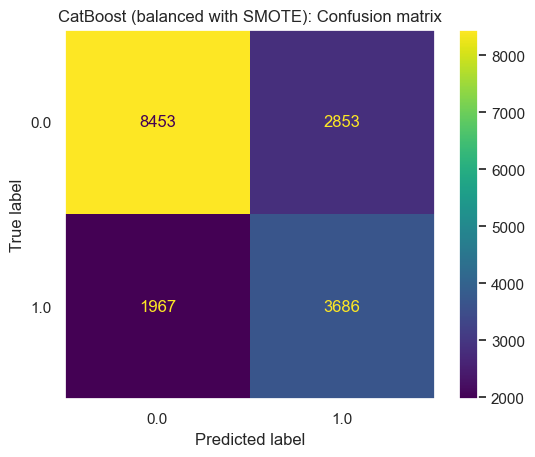

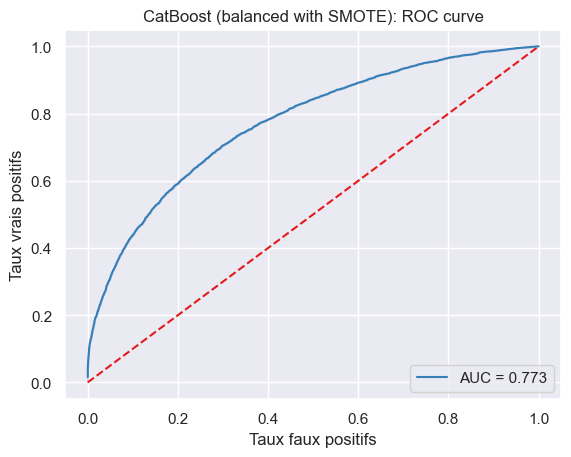

,precision,recall,f1-score,support
0.0,0.811228,0.747656,0.778146,11306.000000
1.0,0.563695,0.652043,0.604659,5653.000000
accuracy,0.715785,0.715785,0.715785,0.715785
macro avg,0.687462,0.699850,0.691402,16959.000000
weighted avg,0.728717,0.715785,0.720317,16959.000000


Business score = 1.3280853823928298


KeyError: 'n_estimators'

In [21]:
%%time

# Create CatBoost classifier
cbcmb = CatBoostClassifier(random_state = rs)
cbcmb_name = 'CatBoost (balanced with SMOTE)'

# Train model
start_cbb = time.time()
cbcmb.fit(X_train_scaled_smote, y_train_smote)
end_cbb = time.time()
time_cbb = round(end_cbb - start_cbb, 2)

# Compute results
cbcmb_business_score, cbcmb_auc, cbcmb_report = \
                        compute_classification_results(cbcmb, 
                                                       cbcmb_name, 
                                                       X_test_scaled_smote, 
                                                       y_test_smote)

# Save logs
cbcmb_params = cbcmb.get_params()
log_mlflow(cbcmb, cbcmb_name,
           custom_score=cbcmb_business_score,
           auc_score=cbcmb_auc,
           f1_score=cbcmb_report.loc['weighted avg', 'f1-score'], 
           acc_score=cbcmb_report.loc['accuracy', 'precision'],
           n_estimator=cbcmb_params['n_estimators'],
           max_depth=cbcmb_params['max_depth'], 
           train_class_0=Counter(y_train_smote)[0],
           train_class_1=Counter(y_train_smote)[1])

## Comparaison et sélection de modèle

In [22]:
# Paramétrage dataframe des résultats de la modélisation (avec et sans SMOTE)
results_df = pd.DataFrame({
    'Model' :['RandomForest (unbalanced)', 
              'RandomForest (SMOTE)',
              'XGBoost (unbalanced)', 
              'XGBoost (SMOTE)',
              'LightGBM (unbalanced)',
              'LightGBM (SMOTE)', 
              'CatBoost (unbalanced)',
              'CatBoost (SMOTE)'],
    'Business score' : [rf_business_score,
                        rfb_business_score,
                        xgbc_business_score,
                        xgbcb_business_score,
                        lgbm_business_score,
                        lgbmb_business_score,
                        cbcm_business_score,
                        cbcmb_business_score],
    'Time' : [time_rf,
              time_rfb,
              time_xg, 
              time_xgb,
              time_lgbm,
              time_lgbmb,
              time_cb,
              time_cbb],
    'Accuracy' : [rf_report.loc['accuracy', 'precision'],
                  rfb_report.loc['accuracy', 'precision'],
                  xgbc_report.loc['accuracy', 'precision'],
                  xgbcb_report.loc['accuracy', 'precision'],
                  lgbm_report.loc['accuracy', 'precision'],
                  lgbmb_report.loc['accuracy', 'precision'],
                  cbcm_report.loc['accuracy', 'precision'],
                  cbcmb_report.loc['accuracy', 'precision']],
    'Precision' : [rf_report.loc['macro avg', 'precision'],
                   rfb_report.loc['macro avg', 'precision'],
                   xgbc_report.loc['macro avg', 'precision'],
                   xgbcb_report.loc['macro avg', 'precision'],
                   lgbm_report.loc['macro avg', 'precision'],
                   lgbmb_report.loc['macro avg', 'precision'],
                   cbcm_report.loc['macro avg', 'precision'],
                   cbcmb_report.loc['macro avg', 'precision']],
    'Recall' : [rf_report.loc['macro avg', 'recall'],
                rfb_report.loc['macro avg', 'recall'],
                xgbc_report.loc['macro avg', 'recall'],
                xgbcb_report.loc['macro avg', 'recall'],
                lgbm_report.loc['macro avg', 'recall'],
                lgbmb_report.loc['macro avg', 'recall'],
                cbcm_report.loc['macro avg', 'recall'],
                cbcmb_report.loc['macro avg', 'recall']],
    'F-1 score' : [rf_report.loc['macro avg', 'f1-score'],
                   rfb_report.loc['macro avg', 'f1-score'],
                   xgbc_report.loc['macro avg', 'f1-score'],
                   xgbcb_report.loc['macro avg', 'f1-score'],
                   lgbm_report.loc['macro avg', 'f1-score'],
                   lgbmb_report.loc['macro avg', 'f1-score'],
                   cbcm_report.loc['macro avg', 'f1-score'],
                   cbcmb_report.loc['macro avg', 'f1-score']],
    'AUC score' : [rf_auc,
                   rfb_auc,
                   xgbc_auc,
                   xgbcb_auc,
                   lgbm_auc,
                   lgbmb_auc,
                   cbcm_auc,
                   cbcmb_auc],
})

display(results_df)

,Model,Business score,Time,Accuracy,Precision,Recall,F-1 score,AUC score
0,RandomForest (unbalanced),0.806266,240.65,0.919271,0.709683,0.500643,0.480372,0.648676
1,RandomForest (SMOTE),2.607229,44.60,0.695973,0.662036,0.580046,0.570085,0.689147
2,XGBoost (unbalanced),0.771097,66.04,0.914491,0.625310,0.523121,0.525679,0.712149
3,XGBoost (SMOTE),1.577098,20.36,0.722035,0.686362,0.683266,0.684711,0.751933
4,LightGBM (unbalanced),0.796446,7.27,0.919580,0.748140,0.506782,0.493172,0.759487
5,LightGBM (SMOTE),1.936789,2.73,0.757179,0.745706,0.676720,0.689471,0.794249
6,CatBoost (unbalanced),0.772609,98.10,0.917808,0.672748,0.521894,0.522994,0.751449
7,CatBoost (SMOTE),1.328085,49.18,0.715785,0.687462,0.699850,0.691402,0.772940


Le meilleur modèle est ici le LightGBM (SMOTE), selon les critères de :  
  
- score AUC  
- temps d'entraînement  
- Precision

## Hyperparamètres du modèle et optimisation

In [23]:
# Création du modèle LightGBM SMOTE tuned
lgbmb = ltb.LGBMClassifier(random_state = rs)
lgbmb_name = 'LightGBM (SMOTE) tuned'

In [24]:
# Définition des listes d'hyperparamètres à tester avec GridSearch
max_depth = [5, 10, 15]
num_leaves = [30, 40, 50]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.6, 0.7, 0.8]
colsample_bytree = [0.5, 0.55, 0.6]

tuned_param = {'max_depth' : max_depth,
               'num_leaves' : num_leaves,
               'learning_rate' : learning_rate,
               'subsample' : subsample,
               'colsample_bytree' : colsample_bytree}

#### GridSearchCV

In [25]:
%%time

gs = model_selection.GridSearchCV(estimator = lgbmb,
                    param_grid = tuned_param,
                    cv = 5,
                    refit = 'custom_score',
                    n_jobs = -1)

gs.fit(X_train_scaled_smote, y_train_smote)

print('Modèle : {}'.format(lgbmb_name))
print("Meilleur score : ", gs.best_score_)
print("Meilleurs paramètres : ", gs.best_params_)
print("Coef. détermination moyen sur base de test : {}".format(gs.best_estimator_))

Modèle : LightGBM (SMOTE) tuned
Meilleur score :  0.7384658650249529
Meilleurs paramètres :  {'colsample_bytree': 0.55, 'learning_rate': 0.1, 'max_depth': 15, 'num_leaves': 50, 'subsample': 0.6}
Coef. détermination moyen sur base de test : LGBMClassifier(colsample_bytree=0.55, max_depth=15, num_leaves=50,
               random_state=42, subsample=0.6)
CPU times: total: 32.6 s
Wall time: 29min 47s


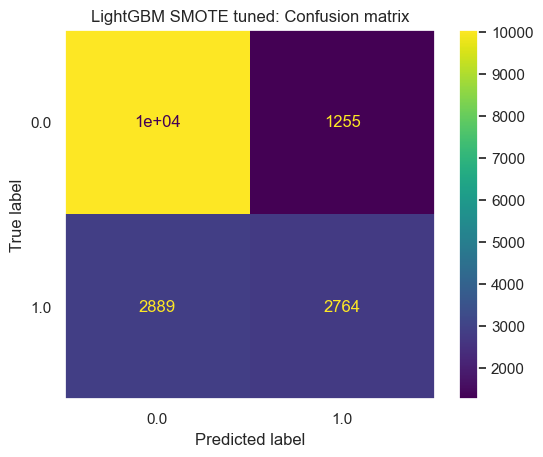

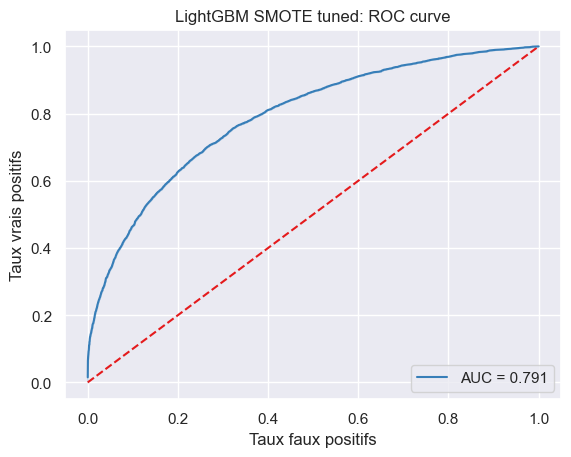

,precision,recall,f1-score,support
0.0,0.776739,0.888997,0.829085,11306.000000
1.0,0.687733,0.488944,0.571547,5653.000000
accuracy,0.755646,0.755646,0.755646,0.755646
macro avg,0.732236,0.688970,0.700316,16959.000000
weighted avg,0.747070,0.755646,0.743239,16959.000000


Business score = 1.7775222595671916
CPU times: total: 1min 2s
Wall time: 39 s


In [26]:
%%time

# Application des paramètres optimaux
lgbmb_gs = ltb.LGBMClassifier(random_state = rs)
lgbmb_gs_name = 'LightGBM SMOTE tuned'
lgbmb_gs.set_params(**gs.best_params_)

# Fit du modèle avec les paramètres optimisés
lgbmb_gs.fit(X_train_scaled_smote, y_train_smote)

# Calcul des prédictions et scores
lgbmb_gs_business_score, lgbmb_gs_auc, lgbmb_gs_report = \
                    compute_classification_results(lgbmb_gs, 
                                                   lgbmb_gs_name,
                                                   X_test_scaled_smote,
                                                   y_test_smote)

lgbmb_gs_params = lgbmb_gs.get_params()
log_mlflow(lgbmb_gs, lgbmb_gs_name,
           custom_score = lgbmb_gs_business_score,
           auc_score = lgbmb_gs_auc,
           f1_score = lgbmb_gs_report.loc['weighted avg', 'f1-score'], 
           acc_score = lgbmb_gs_report.loc['accuracy', 'precision'],
           n_estimator = lgbmb_gs_params['n_estimators'],
           max_depth = lgbmb_gs_params['max_depth'], 
           train_class_0 = Counter(y_train_smote)[0],
           train_class_1 = Counter(y_train_smote)[1])

## Features importance

In [27]:
# Modèle retenu : LightGBM (SMOTE) tuned
model = lgbmb_gs

#### Explainer SHAP (Shapley Additive exPlanations)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


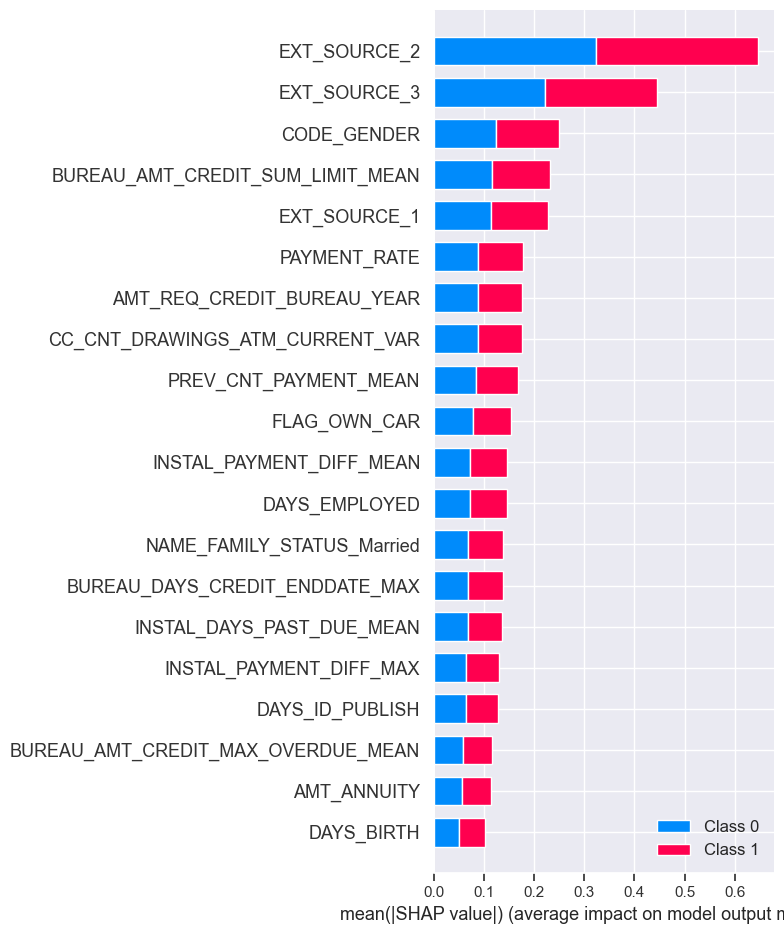

In [28]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled_smote)
expected_value = explainer.expected_value

shap.summary_plot(shap_values, 
                  plot_type="bar", 
                  feature_names = features_names)

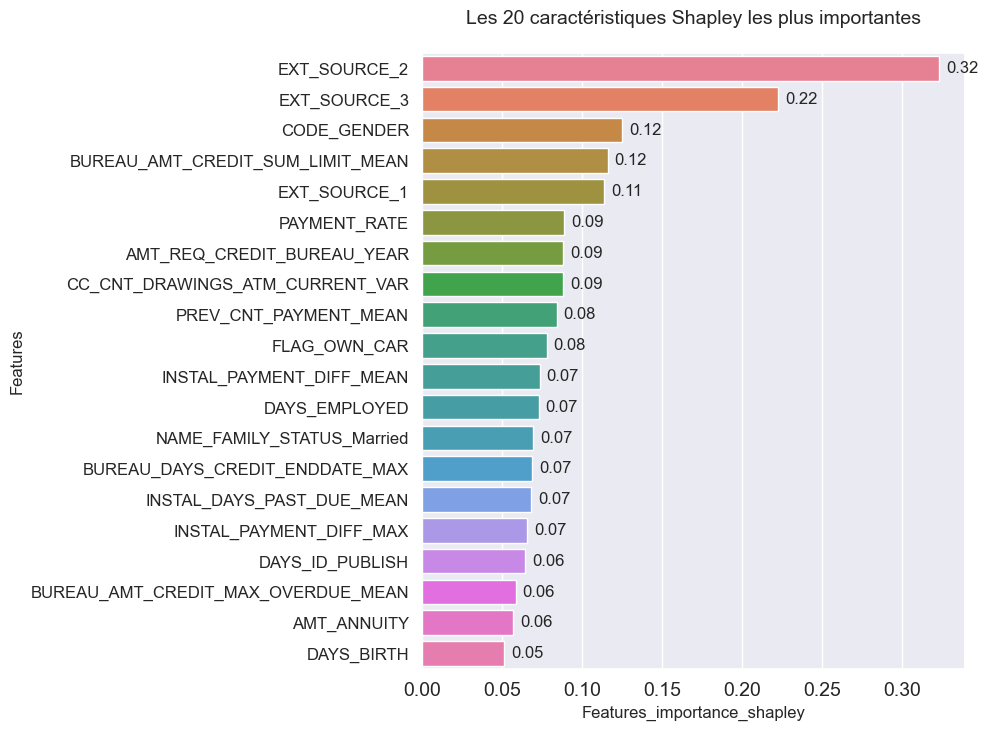

In [29]:
vals =  np.abs(shap_values[1]).mean(0)
df_feature_importance = pd.DataFrame(list(zip(features_names, vals)), 
                                     columns=['Features','Features_importance_shapley'])
df_feature_importance.sort_values(by=['Features_importance_shapley'], 
                                  ascending=False, 
                                  inplace=True)

df_feature_importance_20 = df_feature_importance.head(20)

# Graphique des caractéristiques les plus importantes
fig, ax = plt.subplots()
ax = sns.barplot(x="Features_importance_shapley", 
                 y="Features", 
                 data=df_feature_importance_20, 
                 palette="husl")

# Ajouter les annotations sur les barres
for p in ax.patches:
    ax.annotate("%.2f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
                xytext=(5, 0), textcoords='offset points', ha="left", va="center")

# Ajouter des textes aux labels, titre etc.
fig.set_size_inches(7, 8)
ax.set_title("Les 20 caractéristiques Shapley les plus importantes\n", fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


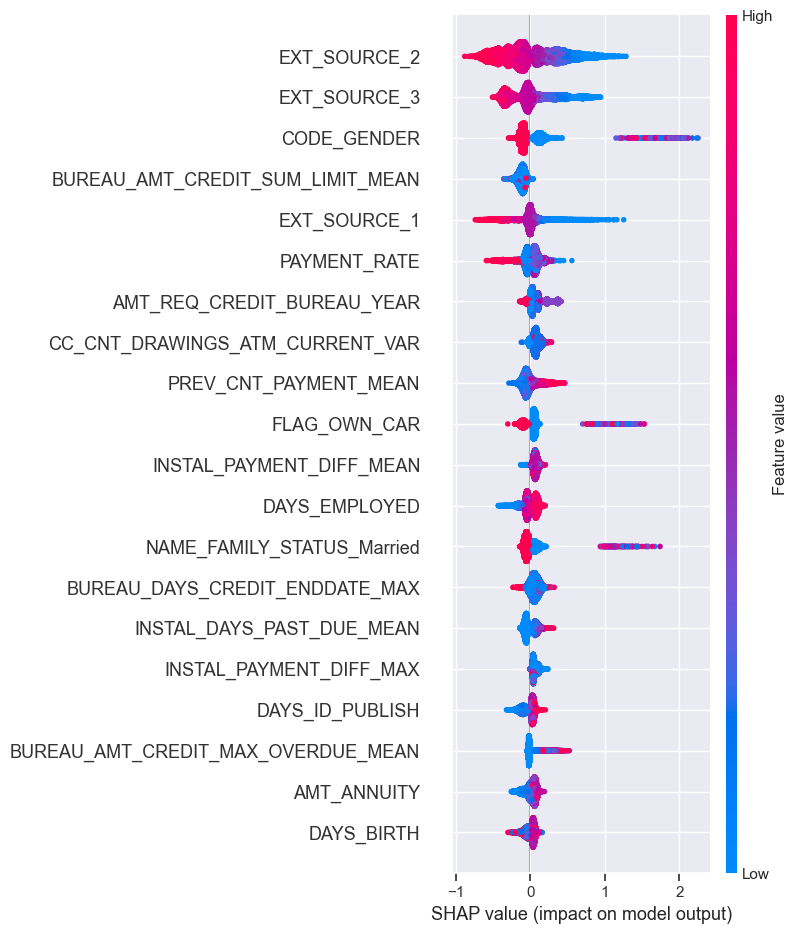

In [30]:
shap.summary_plot(shap_values[1], 
                  X_test_scaled_smote, 
                  show=False, 
                  feature_names = features_names)

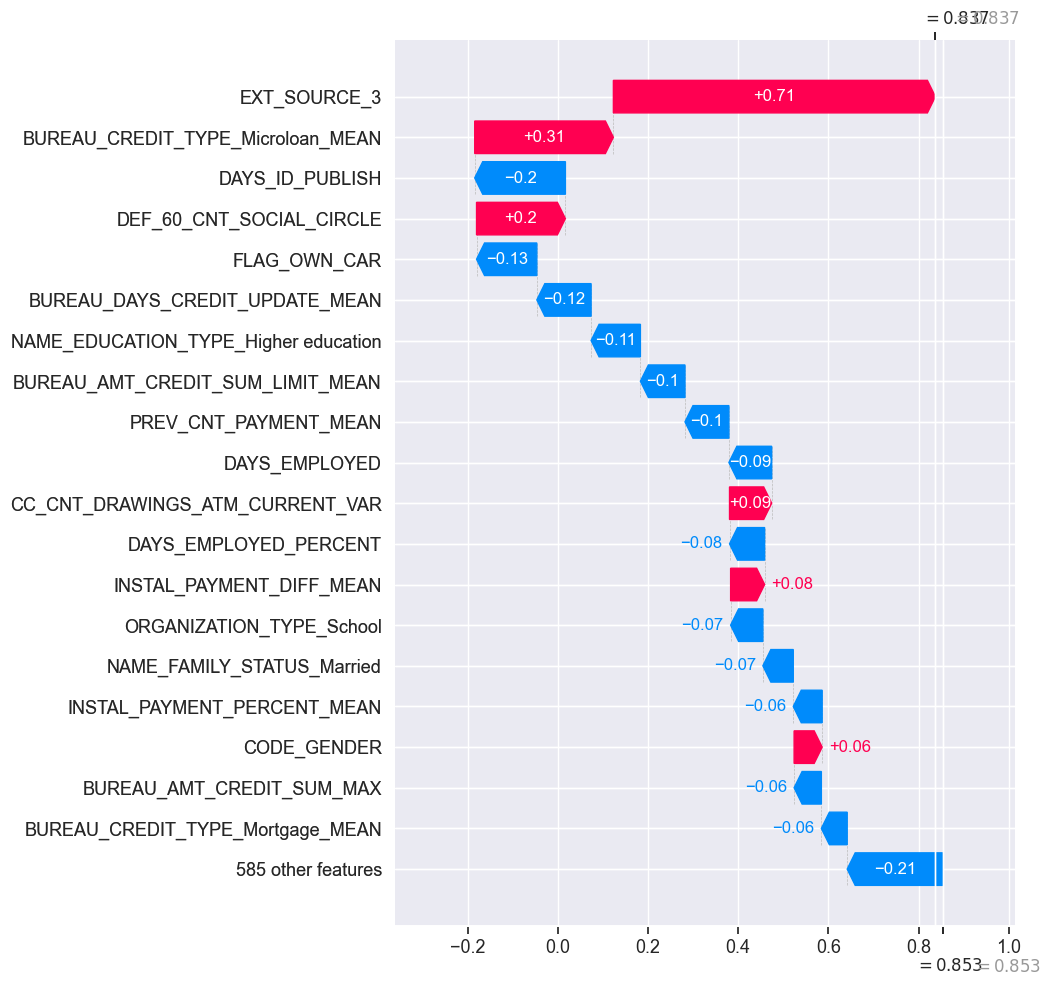

In [31]:
index_client = 30
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],
                                        shap_values[1][index_client],
                                        feature_names = features_names,
                                        max_display = 20)

### Sauvegarde du modèle au format Pickle

In [32]:
save_path = './notebooks/saved_model/'

model_name = 'LightGBM_smote_tuned.pckl'
pickle.dump(model, open(save_path+model_name, 'wb'))

### Sauvegarde de la signature du modèle (MLFlow)

In [33]:
signature = infer_signature(X_train_scaled, y_train)

In [34]:
mlflow.sklearn.save_model(model, 'mlflow_model', signature=signature)